In [ ]:
import torch
import urllib

from PIL import Image
from torchvision import transforms
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import shapely.geometry as geometry
import math
import copy

import os
import pandas as pd
from torchvision.io import read_image
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from torchvision.models import DenseNet121_Weights

In [ ]:
torch.manual_seed(666)
np.random.seed(666)

## 1. Exploratory Data Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = "/content/drive/MyDrive/robotic-CornellGrasp-V2/robotic_data/"

In [ ]:
class GraspingBox:
  """
  Here we define a 5 dim representation of grasping box (x, y, w, h, theta)
  """
  def __init__(self, coords):
    self.coords = coords # 4*2 np array

  def get_center_xy(self):
    center = np.mean(self.coords, axis=0).astype(int)
    return center

  def get_width(self):
    dx = self.coords[0][0] - self.coords[1][0]
    dy = self.coords[0][1] - self.coords[1][1]
    w = np.sqrt(dx**2 + dy**2)
    return w

  def get_height(self):
    dx = self.coords[1][0] - self.coords[2][0]
    dy = self.coords[1][1] - self.coords[2][1]
    h = np.sqrt(dx**2 + dy**2)
    return h

  def get_angle(self):
    # return the angle of grasping box with respect to positive x-axis
    dx = self.coords[0][0] - self.coords[1][0]
    dy = self.coords[0][1] - self.coords[1][1]
    theta = (np.arctan2(-dy,dx) + np.pi/2) % np.pi - np.pi/2
    return theta

  def get_repr(self):
    x, y = self.get_center_xy()[0], self.get_center_xy()[1]
    w = self.get_width()
    h = self.get_height()
    theta = self.get_angle()
    return x, y, w, h, theta

  def visualize_rectangle(self):
    return patch.Polygon(self.coords,facecolor="none", edgecolor="red")

In [ ]:
# here we preprocess image and visualize a sample of (image, label)
photo_path = "".join([root_path, "pcd0100r.png"])

input_image = Image.open(photo_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
coord_path = "".join([root_path, "pcd0100cpos.txt"])
with open(coord_path, "r") as f:
    coord = [s.strip().split(' ') for s in f.readlines()]

coord = np.array(coord).astype(float).astype('int')
rectangles = np.array([coord[i*4:i*4+4, :] for i in range(len(coord)//4)])

print(rectangles.shape) # n_rectangles, n_points_per_recentangles, x/y

(4, 4, 2)


grasping box 1
x: 280, y: 334, w: 56.22277118748239, h: 26.076809620810597, theta: -0.08904958263449814


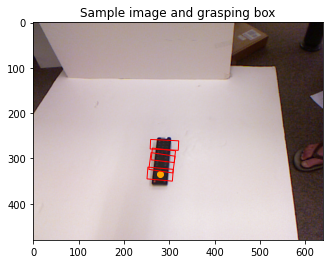

In [ ]:
im = plt.imread(photo_path)
im = plt.imshow(im)

for i in range(len(rectangles)):
  # Create a Polygon patch
  ax = plt.gca()
  rect = patch.Polygon(rectangles[i], facecolor="none", edgecolor="red")
  ax.add_patch(rect)

box = GraspingBox(rectangles[0])
x, y, w, h, theta = box.get_repr()

plt.scatter(x, y, c='orange')
print("grasping box 1")
print("x: {}, y: {}, w: {}, h: {}, theta: {}".format(x, y, w, h, theta))

plt.title("Sample image and grasping box")
plt.show()

## 2. Load and preprocess data

In [ ]:
# load all photos and grasp locations
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, txt_list, transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.txt_list = txt_list
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.txt_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.txt_list[idx].replace('cpos.txt', 'r.png'))
        image = Image.open(img_path)
        label = self.img_labels[idx,:]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [ ]:
# load labels from txt file
dir_list = os.listdir(root_path)
txt_list = list()
data_percent = 0.75

for k in dir_list:
    if k.endswith('cpos.txt'):
      txt_list.append(k)

txt_list = txt_list[:int(data_percent*len(txt_list))]
labels = np.zeros((len(txt_list), 8)) # stores (x1, y1), (x2, y2), (x3, y3), (x4, y4) for each image
full_labels = [] # stores all grasping boxes for each image
idx_dict = {}

for i in range(len(txt_list)):
    coord_path = "".join([root_path, txt_list[i]])
    idx_dict[txt_list[i]] = i
    with open(coord_path, "r") as f:
        coord = [s.strip().split(' ') for s in f.readlines()]
    labels[i] = np.array(coord).astype('float').astype('int')[0:4, :].flatten()
    full_labels.append(np.array(coord).astype('float').astype('int').reshape(-1, 8))

In [ ]:
print(txt_list)
print(labels.shape)

['pcd0759cpos.txt', 'pcd0760cpos.txt', 'pcd0761cpos.txt', 'pcd0762cpos.txt', 'pcd0763cpos.txt', 'pcd0764cpos.txt', 'pcd0765cpos.txt', 'pcd0766cpos.txt', 'pcd0767cpos.txt', 'pcd0768cpos.txt', 'pcd0769cpos.txt', 'pcd0770cpos.txt', 'pcd0771cpos.txt', 'pcd0772cpos.txt', 'pcd0774cpos.txt', 'pcd0773cpos.txt', 'pcd0775cpos.txt', 'pcd0776cpos.txt', 'pcd0777cpos.txt', 'pcd0779cpos.txt', 'pcd0778cpos.txt', 'pcd0780cpos.txt', 'pcd0781cpos.txt', 'pcd0782cpos.txt', 'pcd0784cpos.txt', 'pcd0783cpos.txt', 'pcd0785cpos.txt', 'pcd0786cpos.txt', 'pcd0787cpos.txt', 'pcd0789cpos.txt', 'pcd0788cpos.txt', 'pcd0790cpos.txt', 'pcd0791cpos.txt', 'pcd0792cpos.txt', 'pcd0793cpos.txt', 'pcd0795cpos.txt', 'pcd0794cpos.txt', 'pcd0796cpos.txt', 'pcd0797cpos.txt', 'pcd0798cpos.txt', 'pcd0800cpos.txt', 'pcd0799cpos.txt', 'pcd0801cpos.txt', 'pcd0802cpos.txt', 'pcd0803cpos.txt', 'pcd0805cpos.txt', 'pcd0804cpos.txt', 'pcd0806cpos.txt', 'pcd0807cpos.txt', 'pcd0808cpos.txt', 'pcd0809cpos.txt', 'pcd0810cpos.txt', 'pcd0811cpo

In [ ]:
# convert labels to 5 dim representation of grasping box
rectangles = np.zeros((len(labels), 5)) # store x, y, w, h, theta for each rectangle

for i in range(len(labels)):
  coords = labels[i].reshape(4, 2)
  box = GraspingBox(coords)
  rectangles[i] = box.get_repr()

print(rectangles.shape)

(663, 5)


## 3. Define Training and Utility function

In [ ]:
def train_val_test_split(X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=666):
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_size, random_state=random_state)
  x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_size/(test_size + val_size), random_state=random_state) 
  return x_train, x_val, x_test, y_train, y_val, y_test

In [ ]:
# train the new DenseNet using robot data
def train(args, model, train_loader, val_loader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  torch.manual_seed(666)

  print(device)

  # Use MSE loss function for grasp location and initialize Adam optimizer
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.classifier.parameters(), lr=args.learning_rate)

  train_losses = []
  val_losses = []

  for epoch in range(args.max_epochs):
    model.train()
    mse_train_loss = []

    # loop over each batch
    for batch, (x, y) in enumerate(train_loader):
      image = x.float().cuda()
      label = y.float().cuda()
      
      # forward pass
      pred = model(image)
      loss = criterion(pred, label)
      mse_train_loss.append(loss.item())
                        
      # backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # evaluate model and print loss
    train_loss = np.mean(mse_train_loss)
    val_loss = run_validation(args, model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print("Epoch [%d/%d], Train Loss: %.4f, Val Loss: %.4f" % (epoch + 1, args.max_epochs, train_loss, val_loss))

  return model, train_losses, val_losses

In [ ]:
def run_validation(args, model, val_loader):
  model.eval()
  losses = []

  with torch.no_grad():
      for i, (images, labels) in enumerate(val_loader):
          images = images.float().cuda()
          labels = labels.float().cuda()

          output = model(images)
          criterion = nn.MSELoss()
          loss = criterion(output, labels)
          losses.append(loss.item())

      val_loss = np.mean(losses)

  return val_loss

In [ ]:
def weighted_mse_loss(input, target, weight):
    return (weight * (input - target) ** 2)

## 4. Transfer Learning

In [ ]:
# define hyperparameters for model
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict()
args_dict = {
    "learning_rate": 1e-2,
    "train_batch_size": 32,
    "val_batch_size": 16,
    "test_batch_size": 16,
    "max_epochs": 50
}
args.update(args_dict)

In [ ]:
# load data using Dataset and DataLoader (split into train/test data)
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(txt_list, rectangles, train_size=0.8, val_size=0.1, test_size=0.1, random_state=666)

train_set = CustomImageDataset(annotations_file=y_train, img_dir=root_path, txt_list=X_train, transform=preprocess, target_transform=None)
val_set = CustomImageDataset(annotations_file=y_val, img_dir=root_path, txt_list=X_val, transform=preprocess, target_transform=None)
test_set = CustomImageDataset(annotations_file=y_test, img_dir=root_path, txt_list=X_test, transform=preprocess, target_transform=None)

train_loader = DataLoader(dataset=train_set, batch_size=args.train_batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=args.val_batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=args.test_batch_size, shuffle=True)

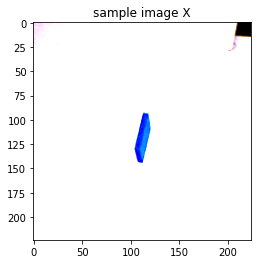

y label:  [317.         240.          42.3792402   15.8113883   -0.33667482]
train/val/test size:  530 66 67


In [ ]:
# visualize input and output data
sample_X = train_set[0][0].numpy()
sample_y = train_set[0][1]

sample_X = np.transpose(sample_X, (1, 2, 0))

plt.imshow(sample_X) # image dampened because centered around 0 and negative values get cut out
plt.title("sample image X")
plt.show()

print("y label: ", sample_y)
print("train/val/test size: ", len(train_set), len(val_set), len(test_set))

Model 1: we use pretrained densenet models with frozen weights


In [ ]:
model1 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)

# freeze parameters from previous layers
for param in model1.parameters():
    param.requires_grad = False

# initialize new layer and add to densenet
num_features = model1.classifier.in_features
num_classes = 5
model1.classifier = nn.Linear(num_features, num_classes)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model 2: we fine tune the densenet models by allowing gradient update on densenet parameters

In [ ]:
model2 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)

# initialize new layer and add to densenet
num_features = model2.classifier.in_features
num_classes = 5
model2.classifier = nn.Linear(num_features, num_classes)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Model 3. we train the densenet model from scratch by randomly initializing the parameters

In [ ]:
# train the model from scratch
def reset_weights(model):
  for layer in model.modules():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [ ]:
model3 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)

# initialize new layer and add to densenet
num_features = model3.classifier.in_features
num_classes = 5
model3.classifier = nn.Linear(num_features, num_classes)

reset_weights(model3)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Reset trainable parameters of layer = Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, 

Here we begin to train and validate our model

In [ ]:
model, train_losses, val_losses = train(args, model1, train_loader, val_loader)

cuda
Epoch [1/3], Train Loss: 27234.3582, Val Loss: 21666.0852
Epoch [2/3], Train Loss: 14684.7937, Val Loss: 10852.4059
Epoch [3/3], Train Loss: 7126.0709, Val Loss: 4298.9422


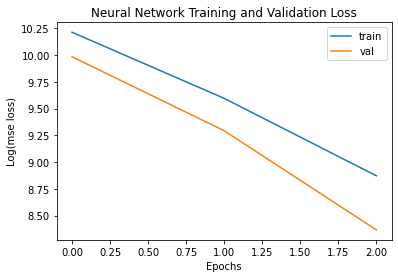

In [ ]:
# visualize training and validation performance
plt.plot(np.arange(args.max_epochs), np.log(train_losses), label="train")
plt.plot(np.arange(args.max_epochs),np.log(val_losses), label="val")
plt.legend()
plt.title("Neural Network Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Log(mse loss)")
plt.show()

## 4. Evaluate the model

Here we use our model to predict (x, y, w, h, theta) of the grasping rectangle and evaluate the prediction with point metric and rectangle metric. 

In [ ]:
def get_bbox_from_repr(repr):
  x_center, y_center, w, h, theta = repr

  x = np.zeros((4, )) # rectangle coord before rotation
  y = np.zeros((4, ))

  x[0], y[0] = x_center-w/2, y_center+h/2
  x[1], y[1] = x_center+w/2, y_center+h/2
  x[2], y[2] = x_center+w/2, y_center-h/2
  x[3], y[3] = x_center-w/2, y_center-h/2

  coord = np.zeros((4, 2))
  for i in range(len(coord)):
    coord[i][1] = np.cos(theta) * (y[i] - y_center) - np.sin(theta) * (x[i] - x_center) + y_center
    coord[i][0] = np.sin(theta) * (y[i] - y_center) + np.cos(theta) * (x[i] - x_center) + x_center

  return coord 

In [ ]:
# evaluate using point metrics
def point_metric_score(y_pred, y_true, threshold=20, data_file=None, multi=False):
  """
  a grasp is considered to be success if 
  the grasping center (x, y) is within threshold pixel distance to ground truth grasp
  """
  center_dist = np.sqrt((y_pred[0] - y_true[0])**2 + (y_pred[1] - y_true[1])**2)
  
  if center_dist < threshold:
    return 1

  if multi:
    y_true_all = full_labels[idx_dict[data_file]]

    for y_true in y_true_all:
      y_true_box = y_true.reshape((4, 2))
      y_true = GraspingBox(y_true_box).get_repr()
      
      center_dist = np.sqrt((y_pred[0] - y_true[0])**2 + (y_pred[1] - y_true[1])**2)
      if center_dist < threshold:
          return 1

  return 0

In [ ]:
# evaluate using rectangle metric
def rectangle_metric_score(y_pred, y_true, angle_threshold=np.pi/6, iou_threshold=0.5, data_file=None, multi=False):
  """
  a grasp is considered to be success if
  1. the grasp angle is within 30 degree of the ground truth grasp
  2. the intersect over union of the predicted grasp and ground truth grasp is greater than iou_threshold
  """
  angle_dist = np.abs(y_pred[4] - y_true[4])

  y_pred_box = get_bbox_from_repr(y_pred)
  y_true_box = get_bbox_from_repr(y_true)

  y_pred_rect = geometry.Polygon([(y_pred_box[i][0], y_pred_box[i][1]) for i in range(len(y_pred_box))])
  y_true_rect = geometry.Polygon([(y_true_box[i][0], y_true_box[i][1]) for i in range(len(y_true_box))])

  iou = y_pred_rect.intersection(y_true_rect).area / y_pred_rect.union(y_true_rect).area

  if angle_dist < angle_threshold and iou > iou_threshold:
    return 1

  # if we compare predicted grasp with multiple ground truth grasp 
  if multi:
    y_true_all = full_labels[idx_dict[data_file]]

    for y_true in y_true_all:
      y_true_box = y_true.reshape((4, 2))
      y_true_rect = geometry.Polygon([(y_true_box[i][0], y_true_box[i][1]) for i in range(len(y_true_box))])
      iou = y_pred_rect.intersection(y_true_rect).area / y_pred_rect.union(y_true_rect).area
      
      y_true = GraspingBox(y_true_box).get_repr()
      angle_dist = np.abs(y_pred[4] - y_true[4])

      if angle_dist < angle_threshold and iou > iou_threshold:
        return 1
    
  return 0

In [ ]:
def run_test(args, model, test_loader, X_test=None, multi=False):
  model.eval()
  losses = []
  point_metric_success = 0
  rectangle_metric_success = 0
  torch.manual_seed(666)

  with torch.no_grad():
      for i, (images, labels) in enumerate(test_loader):
          images = images.float().cuda()
          labels = labels.float().cuda()

          output = model(images)
          criterion = nn.MSELoss()

          loss = criterion(output, labels)
          losses.append(loss.item())

          y_pred, y_true = output.cpu().numpy(), labels.cpu().numpy()
          for j in range(len(y_pred)):
            data_file = X_test[i*args.test_batch_size+j] if multi else None
            point_metric_success = point_metric_success + point_metric_score(y_pred[j], y_true[j], threshold=30, data_file=data_file, multi=multi)
            rectangle_metric_success = rectangle_metric_success + rectangle_metric_score(y_pred[j], y_true[j], 
                                                                                         angle_threshold=np.pi/6, iou_threshold=0.2, data_file=data_file, multi=multi)

  test_loss = np.mean(losses)
  point_metric_success_rate = point_metric_success / len(test_set)
  rectangle_metric_success_rate = rectangle_metric_success / len(test_set)

  return test_loss, point_metric_success_rate, rectangle_metric_success_rate

In [ ]:
def visualize_grasping_box(y_pred, y_true_all, angle_threshold=np.pi/6, iou_threshold=0.5):
  y_pred_box = get_bbox_from_repr(y_pred)
  y_pred_rect = geometry.Polygon([(y_pred_box[i][0], y_pred_box[i][1]) for i in range(len(y_pred_box))])

  for y_true in y_true_all:
    y_true_box = y_true.reshape((4, 2))
    y_true_rect = geometry.Polygon([(y_true_box[i][0], y_true_box[i][1]) for i in range(len(y_true_box))])
    iou = y_pred_rect.intersection(y_true_rect).area / y_pred_rect.union(y_true_rect).area
    
    y_true = GraspingBox(y_true_box).get_repr()
    angle_dist = np.abs(y_pred[4] - y_true[4])
    
    if angle_dist < angle_threshold and iou > iou_threshold:
      print("angle distance: ", angle_dist)
      print("iou: ", iou)
      return y_true_box

  return None

In [ ]:
# evaluate the model with test dataset
test_loss, point_metric_success_rate, rectangle_metric_success_rate = run_test(args, model, test_loader, X_test, multi=True)
print("average test MSE loss: ", test_loss)
print("point success rate: ", point_metric_success_rate)
print("rectangle success rate: ", rectangle_metric_success_rate)

/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


average test MSE loss:  4317.867236328125
point success rate:  0.0
rectangle success rate:  0.0


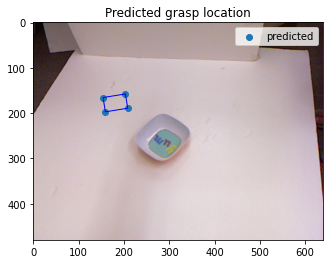

In [ ]:
# predict for one test image sample
idx = 6
image, label = test_set[idx][0], test_set[idx][1]
x = image.unsqueeze(0).cuda()
output = model(x).detach().cpu().numpy()[0]

# visualize test image for this sample
photo_path = os.path.join(root_path, X_test[idx].replace('cpos.txt', 'r.png'))
im = plt.imread(photo_path)
im = plt.imshow(im)

# visualize label prediction for this sample
predict_coord = get_bbox_from_repr(output)
# true_coord = get_bbox_from_repr(label)
true_coords = full_labels[idx_dict[X_test[idx]]]
true_coord = visualize_grasping_box(output, y_true_all=true_coords, angle_threshold=np.pi/6, iou_threshold=0)

ax = plt.gca()
rect = patch.Polygon(predict_coord, facecolor="none", edgecolor="blue")
plt.scatter(predict_coord[:, 0], predict_coord[:, 1], label="predicted")
ax.add_patch(rect)

if true_coord:
  plt.scatter(true_coord[:, 0], true_coord[:, 1], label="true")
  rect2 = patch.Polygon(true_coord, facecolor="none", edgecolor="orange")
  ax.add_patch(rect2)

plt.legend()
plt.title("Predicted grasp location")
plt.show()

## 6. Cross Validation

In [ ]:
k = 8
splits = KFold(n_splits=k,shuffle=True,random_state=42)

In [ ]:
dataset = ConcatDataset([train_set, val_set, test_set])

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(txt_list, rectangles, train_size=0.8, val_size=0.1, test_size=0.1, random_state=666)
X = X_train + X_val + X_test
print(X)

['pcd0571cpos.txt', 'pcd0943cpos.txt', 'pcd0746cpos.txt', 'pcd0688cpos.txt', 'pcd0392cpos.txt', 'pcd0418cpos.txt', 'pcd0518cpos.txt', 'pcd0419cpos.txt', 'pcd0949cpos.txt', 'pcd0758cpos.txt', 'pcd0692cpos.txt', 'pcd0620cpos.txt', 'pcd0172cpos.txt', 'pcd0831cpos.txt', 'pcd0883cpos.txt', 'pcd0182cpos.txt', 'pcd0708cpos.txt', 'pcd0600cpos.txt', 'pcd0783cpos.txt', 'pcd0778cpos.txt', 'pcd0382cpos.txt', 'pcd0818cpos.txt', 'pcd0175cpos.txt', 'pcd0815cpos.txt', 'pcd0841cpos.txt', 'pcd1032cpos.txt', 'pcd0515cpos.txt', 'pcd0898cpos.txt', 'pcd0495cpos.txt', 'pcd0409cpos.txt', 'pcd0416cpos.txt', 'pcd0730cpos.txt', 'pcd0854cpos.txt', 'pcd0670cpos.txt', 'pcd0923cpos.txt', 'pcd0934cpos.txt', 'pcd0886cpos.txt', 'pcd0657cpos.txt', 'pcd0739cpos.txt', 'pcd0602cpos.txt', 'pcd0765cpos.txt', 'pcd0427cpos.txt', 'pcd0556cpos.txt', 'pcd0649cpos.txt', 'pcd0826cpos.txt', 'pcd0458cpos.txt', 'pcd0651cpos.txt', 'pcd0731cpos.txt', 'pcd0637cpos.txt', 'pcd0461cpos.txt', 'pcd0596cpos.txt', 'pcd0432cpos.txt', 'pcd0760cpo

model 1: pretrained Densenet model with frozen weights

In [ ]:
models = []
train_lossess = []
val_lossess = []
point_metric_success_rates = []
rectangle_metric_success_rates = []

for fold,(train_idx,val_idx) in enumerate(splits.split(dataset)):
    print('Fold', fold)

    model1 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', weights=DenseNet121_Weights)

    # freeze parameters from previous layers
    for param in model1.parameters():
        param.requires_grad = False

    # initialize new layer and add to densenet
    num_features = model1.classifier.in_features
    num_classes = 5
    model1.classifier = nn.Linear(num_features, num_classes)
    
    train_subsampler = SubsetRandomSampler(train_idx)
    val_subsampler = SubsetRandomSampler(val_idx)

    trainloader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=args.train_batch_size, sampler=train_subsampler)
    valloader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=args.val_batch_size, sampler=val_subsampler)

    model1, train_losses, val_losses = train(args, model1, trainloader, valloader)
    models.append(model1)
    train_lossess.append(train_losses)
    val_lossess.append(val_losses)

    # evaluate the model with test dataset
    X_val = np.array(X)[val_idx]
    test_loss, point_metric_success_rate, rectangle_metric_success_rate = run_test(args, model1, valloader, X_val, multi=True)
    point_metric_success_rates.append(point_metric_success_rate)
    rectangle_metric_success_rates.append(rectangle_metric_success_rate)
    
    print("average test MSE loss: ", test_loss)
    print("point success rate: ", point_metric_success_rate)
    print("rectangle success rate: ", rectangle_metric_success_rate)

Fold 0


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda
Epoch [1/3], Train Loss: 26331.8854, Val Loss: 20306.5667
Epoch [2/3], Train Loss: 12858.3161, Val Loss: 9180.2651
Epoch [3/3], Train Loss: 5663.3031, Val Loss: 4033.5722
average test MSE loss:  3989.7632649739585
point success rate:  0.029850746268656716
rectangle success rate:  0.0
Fold 1


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


cuda
Epoch [1/3], Train Loss: 26091.5004, Val Loss: 19499.8413
Epoch [2/3], Train Loss: 12906.3595, Val Loss: 9143.9357
Epoch [3/3], Train Loss: 5633.3371, Val Loss: 3896.2360
average test MSE loss:  3863.0169677734375
point success rate:  0.014925373134328358
rectangle success rate:  0.0
Fold 2


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


cuda
Epoch [1/3], Train Loss: 26361.6567, Val Loss: 19539.1924
Epoch [2/3], Train Loss: 12925.2797, Val Loss: 9289.1170
Epoch [3/3], Train Loss: 5713.1087, Val Loss: 3774.1365
average test MSE loss:  4247.350830078125
point success rate:  0.014925373134328358
rectangle success rate:  0.0
Fold 3


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


cuda
Epoch [1/3], Train Loss: 26308.5184, Val Loss: 19400.9072
Epoch [2/3], Train Loss: 12951.3952, Val Loss: 8294.4959
Epoch [3/3], Train Loss: 5734.1414, Val Loss: 3485.8416


<ipython-input-5-918e33b9093b>:13: RuntimeWarning: overflow encountered in long_scalars
  dx = self.coords[0][0] - self.coords[1][0]
<ipython-input-5-918e33b9093b>:14: RuntimeWarning: overflow encountered in long_scalars
  dy = self.coords[0][1] - self.coords[1][1]
<ipython-input-5-918e33b9093b>:26: RuntimeWarning: overflow encountered in long_scalars
  dx = self.coords[0][0] - self.coords[1][0]
<ipython-input-5-918e33b9093b>:27: RuntimeWarning: overflow encountered in long_scalars
  dy = self.coords[0][1] - self.coords[1][1]


average test MSE loss:  3143.993408203125
point success rate:  0.029850746268656716
rectangle success rate:  0.014925373134328358
Fold 4


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


cuda
Epoch [1/3], Train Loss: 26373.5985, Val Loss: 19420.5124
Epoch [2/3], Train Loss: 13043.9868, Val Loss: 8359.5772
Epoch [3/3], Train Loss: 5656.6020, Val Loss: 3592.2928
average test MSE loss:  3622.375203450521
point success rate:  0.029850746268656716
rectangle success rate:  0.014925373134328358
Fold 5


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


cuda
Epoch [1/3], Train Loss: 26136.7100, Val Loss: 20201.6667
Epoch [2/3], Train Loss: 12950.3874, Val Loss: 8967.3219
Epoch [3/3], Train Loss: 5667.8850, Val Loss: 3805.2367
average test MSE loss:  3726.0101725260415
point success rate:  0.029850746268656716
rectangle success rate:  0.0
Fold 6


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


cuda
Epoch [1/3], Train Loss: 26223.4948, Val Loss: 20657.4092
Epoch [2/3], Train Loss: 12852.2943, Val Loss: 8760.4027
Epoch [3/3], Train Loss: 5592.2274, Val Loss: 3811.0110
average test MSE loss:  3823.6229654947915
point success rate:  0.014925373134328358
rectangle success rate:  0.0
Fold 7


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


cuda
Epoch [1/3], Train Loss: 26154.0591, Val Loss: 19928.2565
Epoch [2/3], Train Loss: 12917.5362, Val Loss: 9197.4448
Epoch [3/3], Train Loss: 5617.8978, Val Loss: 3516.6759
average test MSE loss:  3498.0030517578125
point success rate:  0.0
rectangle success rate:  0.0


In [ ]:
print(val_lossess)
print(point_metric_success_rates)
print(rectangle_metric_success_rates)

[[20306.566731770832, 9180.26513671875, 4033.572224934896], [19499.84130859375, 9143.935709635416, 3896.2360026041665], [19539.1923828125, 9289.117024739584, 3774.136515299479], [19400.9072265625, 8294.495930989584, 3485.841552734375], [19420.512369791668, 8359.577229817709, 3592.2928466796875], [20201.666666666668, 8967.321940104166, 3805.2366943359375], [20657.4091796875, 8760.402669270834, 3811.011027018229], [19928.256510416668, 9197.44482421875, 3516.6758626302085]]
[0.029850746268656716, 0.014925373134328358, 0.014925373134328358, 0.029850746268656716, 0.029850746268656716, 0.029850746268656716, 0.014925373134328358, 0.0]
[0.0, 0.0, 0.0, 0.014925373134328358, 0.014925373134328358, 0.0, 0.0, 0.0]


model 2: fine tune the pretrained model

In [ ]:
models_fine_tuned = []
train_lossess = []
val_lossess = []
point_metric_success_rates = []
rectangle_metric_success_rates = []

for fold,(train_idx,val_idx) in enumerate(splits.split(dataset)):
    print('Fold', fold)
    model2 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', weights=DenseNet121_Weights)

    # initialize new layer and add to densenet
    num_features = model2.classifier.in_features
    num_classes = 5
    model2.classifier = nn.Linear(num_features, num_classes)

    train_subsampler = SubsetRandomSampler(train_idx)
    val_subsampler = SubsetRandomSampler(val_idx)

    trainloader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=args.train_batch_size, sampler=train_subsampler)
    valloader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=args.val_batch_size, sampler=val_subsampler)

    model2, train_losses, val_losses = train(args, model2, trainloader, valloader)
    models_fine_tuned.append(model2)
    train_lossess.append(train_losses)
    val_lossess.append(val_losses)

    # evaluate the model with test dataset
    X_val = np.array(X)[val_idx]
    test_loss, point_metric_success_rate, rectangle_metric_success_rate = run_test(args, model2, valloader, X_val, multi=True)
    point_metric_success_rates.append(point_metric_success_rate)
    rectangle_metric_success_rates.append(rectangle_metric_success_rate)

    print("average test MSE loss: ", test_loss)
    print("point success rate: ", point_metric_success_rate)
    print("rectangle success rate: ", rectangle_metric_success_rate)

Fold 0


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


cuda
Epoch [1/3], Train Loss: 26266.4596, Val Loss: 20278.8545
Epoch [2/3], Train Loss: 12814.4511, Val Loss: 9154.5415
Epoch [3/3], Train Loss: 5638.3400, Val Loss: 4013.6721
average test MSE loss:  3972.912801106771
point success rate:  0.029850746268656716
rectangle success rate:  0.0
Fold 1


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


cuda
Epoch [1/3], Train Loss: 26091.5004, Val Loss: 19499.8413
Epoch [2/3], Train Loss: 12906.3595, Val Loss: 9143.9357
Epoch [3/3], Train Loss: 5633.3371, Val Loss: 3896.2360
average test MSE loss:  3863.0169677734375
point success rate:  0.014925373134328358
rectangle success rate:  0.0
Fold 2


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


cuda
Epoch [1/3], Train Loss: 26361.6567, Val Loss: 19539.1924
Epoch [2/3], Train Loss: 12925.2797, Val Loss: 9289.1170
Epoch [3/3], Train Loss: 5713.1087, Val Loss: 3774.1365
average test MSE loss:  4247.350830078125
point success rate:  0.014925373134328358
rectangle success rate:  0.0
Fold 3


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


cuda
Epoch [1/3], Train Loss: 26308.5184, Val Loss: 19400.9072
Epoch [2/3], Train Loss: 12951.3952, Val Loss: 8294.4959
Epoch [3/3], Train Loss: 5734.1414, Val Loss: 3485.8416


<ipython-input-5-918e33b9093b>:13: RuntimeWarning: overflow encountered in long_scalars
  dx = self.coords[0][0] - self.coords[1][0]
<ipython-input-5-918e33b9093b>:14: RuntimeWarning: overflow encountered in long_scalars
  dy = self.coords[0][1] - self.coords[1][1]
<ipython-input-5-918e33b9093b>:26: RuntimeWarning: overflow encountered in long_scalars
  dx = self.coords[0][0] - self.coords[1][0]
<ipython-input-5-918e33b9093b>:27: RuntimeWarning: overflow encountered in long_scalars
  dy = self.coords[0][1] - self.coords[1][1]


average test MSE loss:  3143.993408203125
point success rate:  0.029850746268656716
rectangle success rate:  0.014925373134328358
Fold 4


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


cuda
Epoch [1/3], Train Loss: 26373.5985, Val Loss: 19420.5124
Epoch [2/3], Train Loss: 13043.9868, Val Loss: 8359.5772
Epoch [3/3], Train Loss: 5656.6020, Val Loss: 3592.2928
average test MSE loss:  3622.375203450521
point success rate:  0.029850746268656716
rectangle success rate:  0.014925373134328358
Fold 5


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


cuda
Epoch [1/3], Train Loss: 26136.7100, Val Loss: 20201.6667
Epoch [2/3], Train Loss: 12950.3874, Val Loss: 8967.3219
Epoch [3/3], Train Loss: 5667.8850, Val Loss: 3805.2367
average test MSE loss:  3726.0101725260415
point success rate:  0.029850746268656716
rectangle success rate:  0.0
Fold 6


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


cuda
Epoch [1/3], Train Loss: 26223.4948, Val Loss: 20657.4092
Epoch [2/3], Train Loss: 12852.2943, Val Loss: 8760.4027
Epoch [3/3], Train Loss: 5592.2274, Val Loss: 3811.0110
average test MSE loss:  3823.6229654947915
point success rate:  0.014925373134328358
rectangle success rate:  0.0
Fold 7


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


cuda
Epoch [1/3], Train Loss: 26154.0591, Val Loss: 19928.2565
Epoch [2/3], Train Loss: 12917.5362, Val Loss: 9197.4448
Epoch [3/3], Train Loss: 5617.8978, Val Loss: 3516.6759
average test MSE loss:  3498.0030517578125
point success rate:  0.0
rectangle success rate:  0.0


In [ ]:
print(val_lossess)
print(point_metric_success_rates)
print(rectangle_metric_success_rates)

[[29664.306966145832, 19439.254557291668, 9556.394124348959], [29209.166341145832, 20021.8583984375, 9509.706217447916], [29364.6904296875, 20035.527018229168, 8962.734781901041], [29528.984049479168, 19817.7060546875, 9901.827392578125], [29378.149088541668, 19562.242838541668, 8586.5244140625], [30270.988932291668, 19696.665690104168, 8575.4873046875], [30870.42578125, 20351.875325520832, 9591.248046875], [29835.228515625, 20497.250325520832, 9136.137044270834]]
[0.0, 0.014925373134328358, 0.029850746268656716, 0.014925373134328358, 0.0, 0.014925373134328358, 0.014925373134328358, 0.0]
[0.0, 0.014925373134328358, 0.0, 0.014925373134328358, 0.0, 0.014925373134328358, 0.0, 0.0]


In [ ]:
# comparing two models to check if they are the same
def check_models(model1, model2):
  count = 0
  n_diff = 0
  layers = []
  
  for name, param in model1.named_parameters():
    layers.append(name)

  for p1, p2 in zip(model1.parameters(), model2.parameters()):
    if p1.data.ne(p2.data).sum() > 0:
      n_parameters = p1.flatten().shape[0]
      print("On {}: {} out of {} parameters are different".format(layers[count], p1.data.ne(p2.data).sum().data, n_parameters))
      n_diff += 1

    count += 1
  
  return False if n_diff > 0 else True

model 3: random initialization and train from scratch

In [ ]:
models_from_scratch = []
train_lossess = []
val_lossess = []
point_metric_success_rates = []
rectangle_metric_success_rates = []

for fold,(train_idx,val_idx) in enumerate(splits.split(dataset)):
    print('Fold', fold)
    model3 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)

    # initialize new layer and add to densenet
    num_features = model3.classifier.in_features
    num_classes = 5
    model3.classifier = nn.Linear(num_features, num_classes)

    reset_weights(model3)
    
    train_subsampler = SubsetRandomSampler(train_idx)
    val_subsampler = SubsetRandomSampler(val_idx)

    trainloader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=args.train_batch_size, sampler=train_subsampler)
    valloader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=args.val_batch_size, sampler=val_subsampler)

    model, train_losses, val_losses = train(args, model3, trainloader, valloader)
    models_from_scratch.append(model)
    train_lossess.append(train_losses)
    val_lossess.append(val_losses)

    # evaluate the model with test dataset
    X_val = np.array(X)[val_idx]
    test_loss, point_metric_success_rate, rectangle_metric_success_rate = run_test(args, model, valloader, X_val, multi=True)
    point_metric_success_rates.append(point_metric_success_rate)
    rectangle_metric_success_rates.append(rectangle_metric_success_rate)
    
    print("average test MSE loss: ", test_loss)
    print("point success rate: ", point_metric_success_rate)
    print("rectangle success rate: ", rectangle_metric_success_rate)

Fold 0
Reset trainable parameters of layer = Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(160, eps=1e-05, momentum=0.1, affine

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Reset trainable parameters of layer = Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(224, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(224, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Reset trainable parameters of layer = Conv2d(224, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(288, 128, kernel_size=(1, 1), stride=(1, 

<ipython-input-5-918e33b9093b>:13: RuntimeWarning: overflow encountered in long_scalars
  dx = self.coords[0][0] - self.coords[1][0]
<ipython-input-5-918e33b9093b>:14: RuntimeWarning: overflow encountered in long_scalars
  dy = self.coords[0][1] - self.coords[1][1]
<ipython-input-5-918e33b9093b>:26: RuntimeWarning: overflow encountered in long_scalars
  dx = self.coords[0][0] - self.coords[1][0]
<ipython-input-5-918e33b9093b>:27: RuntimeWarning: overflow encountered in long_scalars
  dy = self.coords[0][1] - self.coords[1][1]


average test MSE loss:  9289.894287109375
point success rate:  0.014925373134328358
rectangle success rate:  0.014925373134328358
Fold 4
Reset trainable parameters of layer = Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(96, 128, ker

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Reset trainable parameters of layer = Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(288, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Reset trainable parameters of layer = Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(224, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(224, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Reset trainable parameters of layer = Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
print(val_lossess)
print(point_metric_success_rates)
print(rectangle_metric_success_rates)

[[29664.306966145832, 19439.254557291668, 9556.394124348959], [29209.166341145832, 20021.8583984375, 9509.706217447916], [29364.6904296875, 20035.527018229168, 8962.734781901041], [29528.984049479168, 19817.7060546875, 9901.827392578125], [29378.149088541668, 19562.242838541668, 8586.5244140625], [30270.988932291668, 19696.665690104168, 8575.4873046875], [30870.42578125, 20351.875325520832, 9591.248046875], [29835.228515625, 20497.250325520832, 9136.137044270834]]
[0.0, 0.014925373134328358, 0.029850746268656716, 0.014925373134328358, 0.0, 0.014925373134328358, 0.014925373134328358, 0.0]
[0.0, 0.014925373134328358, 0.0, 0.014925373134328358, 0.0, 0.014925373134328358, 0.0, 0.0]


## 7. Visualize Result

In [ ]:
# running cross validation takes too long, so we store the result in txt file
result_path = "/content/drive/MyDrive/robotic-CornellGrasp-V2/results.txt"

In [ ]:
with open(result_path, "r") as f:
    results = np.array([s.strip().split(',') for s in f.readlines()]).astype(float)

In [ ]:
results.shape # n_metrics * n_models (pretrained/fine_tuned/random_initialized) * n_data_group (25/50/75/100), n_fold

(24, 8)

In [ ]:
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
         
    plt.plot([], c=color_code, label=label)
    plt.legend()

In [ ]:
pretrained_point_success_rate = [results[i, :] for i in range(0, len(results), 6)]
fine_tuned_point_success_rate = [results[i+2, :] for i in range(0, len(results), 6)]
random_initialized_point_success_rate = [results[i+4, :] for i in range(0, len(results), 6)]

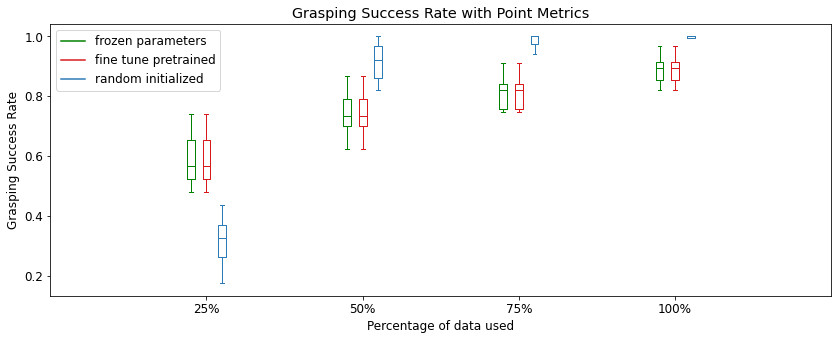

In [ ]:
plt.rcParams["figure.figsize"] = (14,5)
plt.rcParams.update({'font.size': 12})

pretrained_point_success_rate = [results[i, :] for i in range(0, len(results), 6)]
fine_tuned_point_success_rate = [results[i+2, :] for i in range(0, len(results), 6)]
random_initialized_point_success_rate = [results[i+4, :] for i in range(0, len(results), 6)]

ticks = ["25%", "50%", "75%", "100%"]

pretrained_plot = plt.boxplot(pretrained_point_success_rate,
                               positions=np.array(
    np.arange(len(pretrained_point_success_rate)))*2.0-0.2,
                               widths=0.1, showfliers=False)

fine_tuned_plot = plt.boxplot(fine_tuned_point_success_rate,
                               positions=np.array(
    np.arange(len(fine_tuned_point_success_rate)))*2.0,
                               widths=0.1, showfliers=False)

random_init_plot = plt.boxplot(random_initialized_point_success_rate,
                               positions=np.array(
    np.arange(len(random_initialized_point_success_rate)))*2+0.2,
                               widths=0.1, showfliers=False)


define_box_properties(pretrained_plot, '#008000', 'frozen parameters')
define_box_properties(fine_tuned_plot, '#D7191C', 'fine tune pretrained')
define_box_properties(random_init_plot, '#2C7BB6', 'random initialized')

plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.xlabel("Percentage of data used")
plt.ylabel("Grasping Success Rate")
plt.title('Grasping Success Rate with Point Metrics');

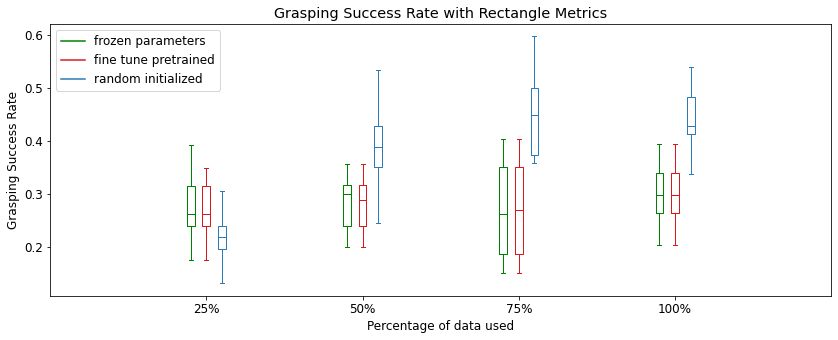

In [ ]:
plt.rcParams["figure.figsize"] = (14,5)
plt.rcParams.update({'font.size': 12})

pretrained_point_success_rate = [results[i+1, :] for i in range(0, len(results), 6)]
fine_tuned_point_success_rate = [results[i+3, :] for i in range(0, len(results), 6)]
random_initialized_point_success_rate = [results[i+5, :] for i in range(0, len(results), 6)]

ticks = ["25%", "50%", "75%", "100%"]

pretrained_plot = plt.boxplot(pretrained_point_success_rate,
                               positions=np.array(
    np.arange(len(pretrained_point_success_rate)))*2.0-0.2,
                               widths=0.1, showfliers=False)

fine_tuned_plot = plt.boxplot(fine_tuned_point_success_rate,
                               positions=np.array(
    np.arange(len(fine_tuned_point_success_rate)))*2.0,
                               widths=0.1, showfliers=False)

random_init_plot = plt.boxplot(random_initialized_point_success_rate,
                               positions=np.array(
    np.arange(len(random_initialized_point_success_rate)))*2+0.2,
                               widths=0.1, showfliers=False)

define_box_properties(pretrained_plot, '#008000', 'frozen parameters')
define_box_properties(fine_tuned_plot, '#D7191C', 'fine tune pretrained')
define_box_properties(random_init_plot, '#2C7BB6', 'random initialized')

plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.xlabel("Percentage of data used")
plt.ylabel("Grasping Success Rate")
plt.title('Grasping Success Rate with Rectangle Metrics');